In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import torch
import torchvision

torch.Size([512, 256])


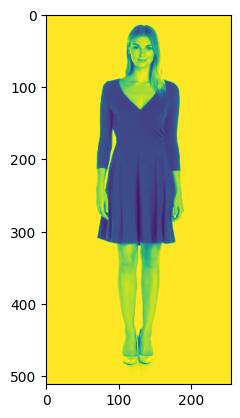

source_img_tensor_list: torch.Size([3, 512, 256]) tensor(1.) tensor(-1.)


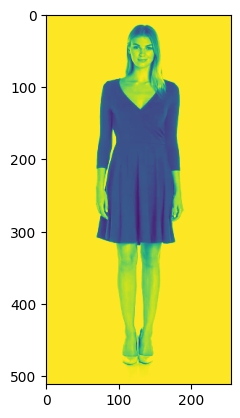

segment_map_tensor_list: torch.Size([512, 256]) tensor(19, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


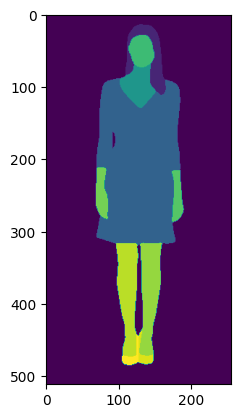

ref_img_tensor: torch.Size([3, 512, 256]) tensor(1.) tensor(-1.)


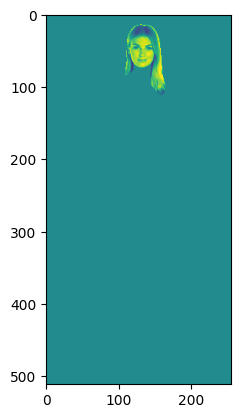

clothes_video_tensor: torch.Size([3, 512, 256]) tensor(1., dtype=torch.float64) tensor(-1., dtype=torch.float64)


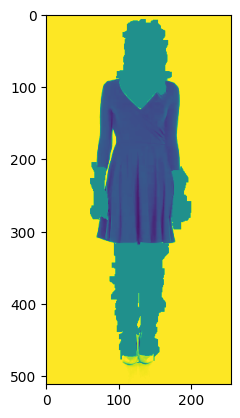

pose_img_tensor_list: torch.Size([3, 512, 256]) tensor(1.) tensor(-1.)


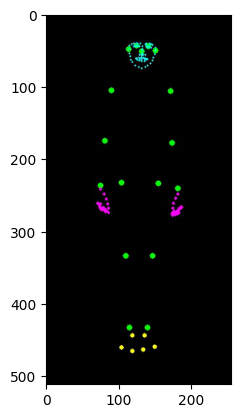

inpainting_mask_list torch.Size([512, 256]) tensor(19., dtype=torch.float64) tensor(0., dtype=torch.float64)


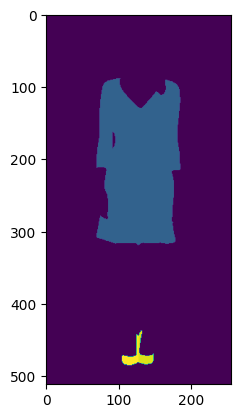

In [101]:
def getMasks(parse_array):
        human_mask = (parse_array==2).astype(np.uint8) + (parse_array==13).astype(np.uint8) 

        heaad_mask_with_arms = (parse_array==2).astype(np.uint8) + (parse_array==13).astype(np.uint8) + \
                    (parse_array==14).astype(np.uint8) + (parse_array==15).astype(np.uint8) + \
                        (parse_array==16).astype(np.uint8) + (parse_array==17).astype(np.uint8) + (parse_array==10).astype(np.uint8)

        heaad_mask_with_arms_bg = (parse_array==2).astype(np.uint8) + (parse_array==13).astype(np.uint8) + \
            (parse_array==14).astype(np.uint8) + (parse_array==15).astype(np.uint8) + \
                (parse_array==16).astype(np.uint8) + (parse_array==17).astype(np.uint8) + (parse_array==10).astype(np.uint8) + \
                (parse_array==0).astype(np.uint8)
        
        heaad_mask_with_arms_bg = 1 - heaad_mask_with_arms_bg

        epsilon_randomness = random.uniform(0.001, 0.005)
        randomness_range = random.choice([ 8, 9, 10])
        kernel_size = random.choice([ 8, 10, 13, 15])

        # predict mask GT, inpainting mask to be dilated 
        heaad_mask_with_arms = 1 - heaad_mask_with_arms.astype(np.float32)
        heaad_mask_with_arms[heaad_mask_with_arms < 0.5] = 0
        heaad_mask_with_arms[heaad_mask_with_arms >= 0.5] = 1
        heaad_mask_with_arms_resized = cv2.resize(heaad_mask_with_arms, (256,512), interpolation=cv2.INTER_NEAREST)

    
        contours, _ = cv2.findContours(((1 - heaad_mask_with_arms_resized) * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        total_area = np.ones((512, 256))
        for contour in contours:
            # max_contour = max(contours, key = cv2.contourArea)
            epsilon = epsilon_randomness * cv2.arcLength(contour, closed=True)  
            approx_contour = cv2.approxPolyDP(contour, epsilon, closed=True)
            randomness = np.random.randint(-randomness_range, randomness_range, approx_contour.shape)
            approx_contour = approx_contour + randomness

            zero_mask = np.zeros((512, 256))
            contours = [approx_contour]

            cv2.drawContours(zero_mask, contours, -1, (255), thickness=cv2.FILLED)

            kernel = np.ones((kernel_size,kernel_size),np.uint8)
            head_mask_with_arms_inpainting = cv2.morphologyEx(zero_mask, cv2.MORPH_CLOSE, kernel)
            head_mask_with_arms_inpainting = head_mask_with_arms_inpainting.astype(np.float32) / 255.0
            head_mask_with_arms_inpainting[head_mask_with_arms_inpainting < 0.5] = 0
            head_mask_with_arms_inpainting[head_mask_with_arms_inpainting >= 0.5] = 1
            head_mask_with_arms_inpainting = heaad_mask_with_arms_resized * (1 - head_mask_with_arms_inpainting)
            total_area = total_area * head_mask_with_arms_inpainting

        total_area = cv2.erode(total_area, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=3)[None]

        total_area = total_area[0] + heaad_mask_with_arms_bg
        total_area[total_area < 0.5] = 0
        total_area[total_area >= 0.5] = 1

        head_mask_tensor = torch.from_numpy(human_mask)     # 头部mask
        total_area_tensor = torch.from_numpy(total_area)    # 全身mask

        return head_mask_tensor, total_area_tensor

def get_tensor(normalize=True, toTensor=True):
    transform_list = []
    if toTensor:
        transform_list += [torchvision.transforms.ToTensor()]

    if normalize:
        transform_list += [
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    return torchvision.transforms.Compose(transform_list)

source_img_list = []     # 原始图像列表
source_img_tensor_list = []
source_path = '/data/muxiangyu/TryonDatasets/datasets/FashionDataset_frames_crop/91-2Jb8DkfS/011.png'
source_img = Image.open(source_path).convert("RGB")
source_img = source_img.resize((256,512), Image.BILINEAR)
source_img_tensor_list.append(get_tensor()(source_img))
source_img_list.append(source_img)

segment_map_list = []    # 语义分割图像列表
segment_map_tensor_list = []
segment_map_path = '/data/muxiangyu/TryonDatasets/datasets/humanParsing/91-2Jb8DkfS/010.png_gray.png'
segment_map = Image.open(segment_map_path)
segment_map = segment_map.resize((256,512), Image.NEAREST)
segment_map_list.append(np.array(segment_map))
segment_map_tensor_list.append(torch.from_numpy(np.array(segment_map)))

head_madk_list = []
total_area_list = []
inpainting_mask_list = []
for parse_array in segment_map_list:
    head_mask_tensor, total_area_tensor = getMasks(parse_array)
    head_madk_list.append(head_mask_tensor)
    total_area_list.append(total_area_tensor)
    inpainting_mask_list.append(torch.from_numpy(parse_array)*total_area_tensor)

pose_img_list = []       # 姿态图像列表
pose_img_tensor_list = []
pose_path = '/data/muxiangyu/TryonDatasets/datasets/mmPose/91-2Jb8DkfS_img/011.jpg'
pose_img = Image.open(pose_path).convert("RGB")
pose_img = pose_img.resize((256,512), Image.BILINEAR)
pose_img_tensor_list.append(get_tensor()(pose_img))
pose_img_list.append(pose_img)

ref_path = '/data/muxiangyu/TryonDatasets/datasets/FashionDataset_frames_crop/91-2Jb8DkfS/025.png'
ref_parse_path = '/data/muxiangyu/TryonDatasets/datasets/humanParsing/91-2Jb8DkfS/025.png_gray.png'
ref_img = Image.open(ref_path).convert("RGB")
ref_parse = Image.open(ref_parse_path)

ref_img = ref_img.resize((256,512), Image.BILINEAR)
ref_img_tensor = get_tensor()(ref_img)
print(ref_img_tensor[0].shape)
plt.imshow(ref_img_tensor[0])
plt.show()
ref_parse = ref_parse.resize((256,512), Image.NEAREST)
ref_head_mask_tensor, ref_total_area_tensor = getMasks(np.array(ref_parse))

ref_img_tensor = ref_img_tensor * ref_head_mask_tensor

clothes_tensor_list = []
for source_img, total_area in zip(source_img_tensor_list, total_area_list):
    clothes = source_img * total_area
    clothes_tensor_list.append(clothes)

print('source_img_tensor_list:', source_img_tensor_list[0].shape, source_img_tensor_list[0].max(), source_img_tensor_list[0].min())
plt.imshow(source_img_tensor_list[0][0])
plt.show()

print('segment_map_tensor_list:', segment_map_tensor_list[0].shape, segment_map_tensor_list[0].max(), segment_map_tensor_list[0].min())
plt.imshow(segment_map_tensor_list[0])
plt.show()

print('ref_img_tensor:', ref_img_tensor.shape, ref_img_tensor.max(), ref_img_tensor.min())
plt.imshow(ref_img_tensor[0])
plt.show()

print('clothes_video_tensor:', clothes_tensor_list[0].shape, clothes_tensor_list[0].max(), clothes_tensor_list[0].min())
plt.imshow(clothes_tensor_list[0][0])
plt.show()

print('pose_img_tensor_list:', pose_img_tensor_list[0].shape, pose_img_tensor_list[0].max(), pose_img_tensor_list[0].min())
plt.imshow(pose_img_list[0])
plt.show()

print('inpainting_mask_list', inpainting_mask_list[0].shape, inpainting_mask_list[0].max(), inpainting_mask_list[0].min())
plt.imshow(inpainting_mask_list[0])
plt.show()

(512, 256, 1)
(512, 256)
contours 5
zero_mask (512, 256) 255.0 0.0


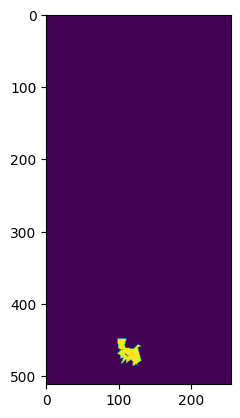

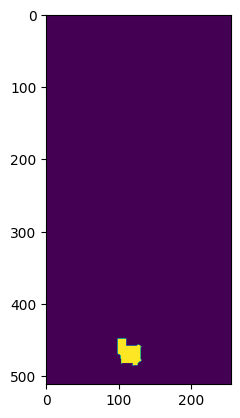

zero_mask (512, 256) 255.0 0.0


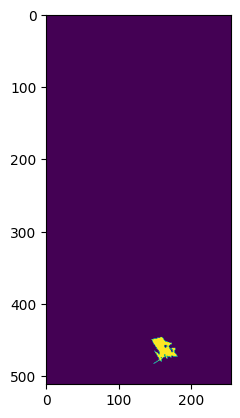

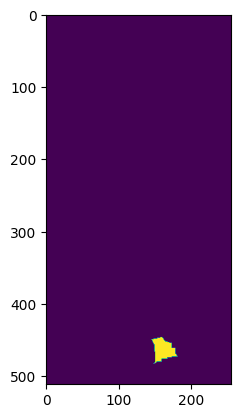

zero_mask (512, 256) 255.0 0.0


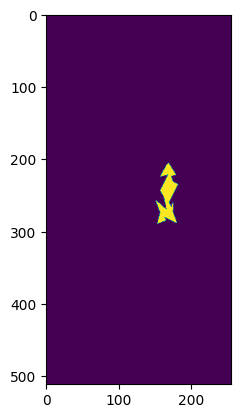

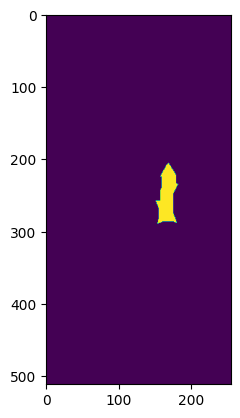

zero_mask (512, 256) 255.0 0.0


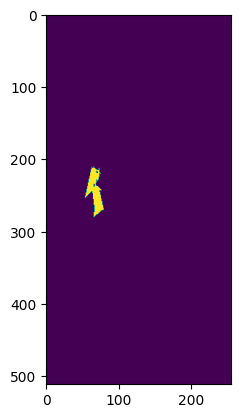

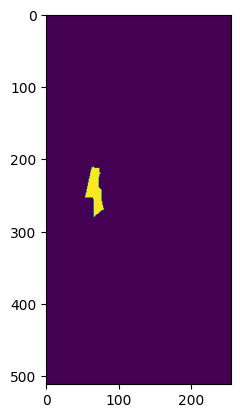

zero_mask (512, 256) 255.0 0.0


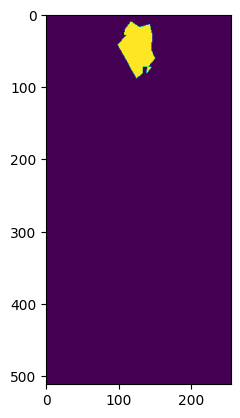

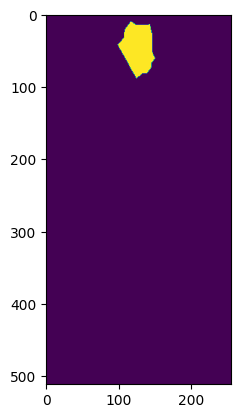

garment_mask_GT


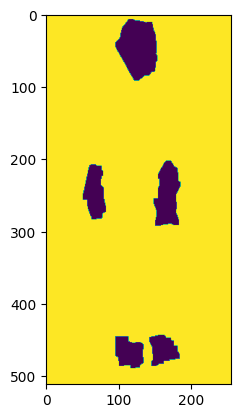

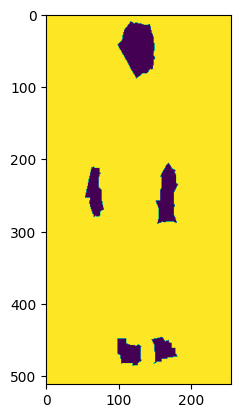

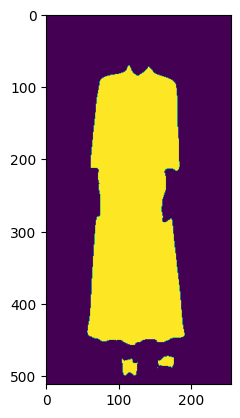

(512, 256) 1.0 0.0
1.0


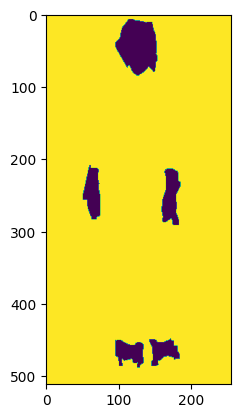

[255 255 255]


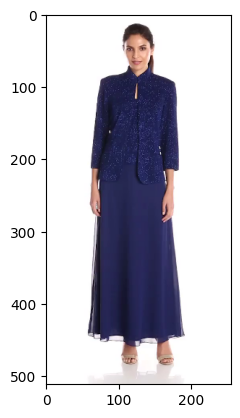

(512, 256, 3) 255.0 0.0


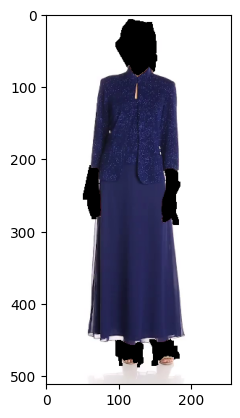

TypeError: Cannot handle this data type: (1, 1, 3), <f8

In [70]:
imagePath = '/data/muxiangyu/TryonDatasets/datasets/FashionDataset_frames_crop/81FyMPk-WIS/000.png'
parsingPath = '/data/muxiangyu/TryonDatasets/datasets/humanParsing/81FyMPk-WIS/000.png_gray.png'

image = Image.open(imagePath)
parsing = Image.open(parsingPath)

image_np = np.array(image)
parsing_np = np.array(parsing)

print(parsing_np[:,:,None].shape)

# print(parsing_np)

# parsing_np = (parsing_np==7).astype(np.uint8) + (parsing_np == 12).astype(np.uint8) + (parsing_np==0) + (parsing_np==6)
heaad_mask_with_arms = (parsing_np==2).astype(np.uint8) + (parsing_np==13).astype(np.uint8) + \
            (parsing_np==14).astype(np.uint8) + (parsing_np==15).astype(np.uint8) + \
                (parsing_np==16).astype(np.uint8) + (parsing_np==17).astype(np.uint8) + (parsing_np==10).astype(np.uint8)

clothes_mask = (parsing_np==2).astype(np.uint8) + (parsing_np==13).astype(np.uint8) + \
            (parsing_np==14).astype(np.uint8) + (parsing_np==15).astype(np.uint8) + \
                (parsing_np==16).astype(np.uint8) + (parsing_np==17).astype(np.uint8) + (parsing_np==10).astype(np.uint8) + \
                (parsing_np==0).astype(np.uint8) 

clothes_mask = 1 - clothes_mask

epsilon_randomness = random.uniform(0.001, 0.005)
randomness_range = random.choice([ 8, 9, 10])
kernel_size = random.choice([ 8, 10, 13, 15])

garment_mask = 1 - heaad_mask_with_arms.astype(np.float32)
garment_mask[garment_mask < 0.5] = 0
garment_mask[garment_mask >= 0.5] = 1
garment_mask_resized = cv2.resize(garment_mask, (256,512), interpolation=cv2.INTER_NEAREST)

print(garment_mask_resized.shape)

contours, _ = cv2.findContours(((1 - garment_mask_resized) * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("contours",len(contours))
total_area = np.ones((512, 256))
for contour in contours:
    # max_contour = max(contours, key = cv2.contourArea)
    epsilon = epsilon_randomness * cv2.arcLength(contour, closed=True)  
    approx_contour = cv2.approxPolyDP(contour, epsilon, closed=True)
    randomness = np.random.randint(-randomness_range, randomness_range, approx_contour.shape)
    approx_contour = approx_contour + randomness

    zero_mask = np.zeros((512, 256))
    contours = [approx_contour]

    cv2.drawContours(zero_mask, contours, -1, (255), thickness=cv2.FILLED)

    print("zero_mask",zero_mask.shape, max(zero_mask.flatten()), min(zero_mask.flatten()))
    plt.imshow(zero_mask)
    plt.show()

    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    garment_mask_inpainting = cv2.morphologyEx(zero_mask, cv2.MORPH_CLOSE, kernel)
    plt.imshow(garment_mask_inpainting)
    plt.show()
    garment_mask_inpainting = garment_mask_inpainting.astype(np.float32) / 255.0
    garment_mask_inpainting[garment_mask_inpainting < 0.5] = 0
    garment_mask_inpainting[garment_mask_inpainting >= 0.5] = 1
    garment_mask_inpainting = garment_mask_resized * (1 - garment_mask_inpainting)
    total_area = total_area * garment_mask_inpainting

garment_mask_GT = cv2.erode(total_area, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=3)[None]


print('garment_mask_GT')
plt.imshow(garment_mask_GT[0])
plt.show()


plt.imshow(total_area)
plt.show()
plt.imshow(clothes_mask)
plt.show()


total_area = garment_mask_GT[0] + clothes_mask
total_area[total_area < 0.5] = 0
total_area[total_area >= 0.5] = 1
print(garment_mask_inpainting.shape, max(garment_mask_inpainting.flatten()), min(garment_mask_inpainting.flatten()))
print(garment_mask_inpainting[0][0])
plt.imshow(total_area)
plt.show()
print(image_np[0][0])
plt.imshow(image_np)
plt.show()
image_np = image_np * total_area[:,:,None]
print(image_np.shape, max(image_np.flatten()), min(image_np.flatten()))

plt.imshow(image_np.astype(np.uint8))
plt.show()

image = Image.fromarray((image_np).astype(np.float64))
image.save('/data/muxiangyu/pythonPrograms/Mannequin2Real/Mannequin2Video/Graphonomy/img/Image1_output.jpg')


In [5]:
source_dir = []
with open('/data/muxiangyu/TryonDatasets/datasets/train_frame_num.txt') as f:
    items = f.readlines()
    
    for item in items:
        framesss = []
        model, allframes = item.strip().split()
        numbers = list(range(int(allframes)))
        selected_frames = random.sample(numbers, 180)
        selected_frames.sort()
        for frame in selected_frames:
            frame = str(frame).zfill(3)
            framesss.append(frame+'.png')
        print(framesss)
        source_dir.append({model: framesss})


['002.png', '003.png', '007.png', '008.png', '009.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '020.png', '021.png', '023.png', '025.png', '027.png', '028.png', '029.png', '032.png', '033.png', '034.png', '035.png', '037.png', '038.png', '039.png', '040.png', '041.png', '043.png', '044.png', '045.png', '047.png', '048.png', '049.png', '050.png', '051.png', '053.png', '054.png', '055.png', '056.png', '057.png', '058.png', '060.png', '061.png', '062.png', '063.png', '064.png', '065.png', '067.png', '068.png', '070.png', '071.png', '073.png', '074.png', '075.png', '076.png', '077.png', '078.png', '080.png', '081.png', '082.png', '083.png', '084.png', '085.png', '088.png', '089.png', '090.png', '091.png', '092.png', '093.png', '094.png', '095.png', '097.png', '099.png', '100.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '109.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png'